In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import chain
import string

In [3]:
species_df = pd.read_csv('species_info.csv', encoding='utf-8');
observ_df = pd.read_csv('observations.csv', encoding='utf-8');

pd.set_option('display.expand_frame_repr', False);

biodiversity_df = pd.merge(species_df, observ_df, on = 'scientific_name', how = 'outer');
print(biodiversity_df);


             category                scientific_name                                       common_names conservation_status                            park_name  observations
0              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN                  Bryce National Park           130
1              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN            Yellowstone National Park           270
2              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN  Great Smoky Mountains National Park            98
3              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN               Yosemite National Park           117
4              Mammal                      Bos bison                              American Bison, Bison                 NaN  

In [4]:
#print(biodiversity_df.columns);
#print(biodiversity_df.category.unique());
biodiversity_df.groupby("category").size();

In [5]:
print(biodiversity_df.dtypes);

category               object
scientific_name        object
common_names           object
conservation_status    object
park_name              object
observations            int64
dtype: object


In [6]:
print(biodiversity_df.isna().sum());

category                   0
scientific_name            0
common_names               0
conservation_status    24752
park_name                  0
observations               0
dtype: int64


In [7]:
duplicates = biodiversity_df.duplicated();
print(duplicates.value_counts());

False    25601
True        31
dtype: int64


In [8]:
biodiversity_df = biodiversity_df.drop_duplicates();
duplicates_bio = biodiversity_df.duplicated();
print(duplicates_bio.value_counts());
print(biodiversity_df.groupby("conservation_status").size());


False    25601
dtype: int64
conservation_status
Endangered             80
In Recovery            24
Species of Concern    732
Threatened             44
dtype: int64


In [283]:
biodiversity_df = biodiversity_df.reset_index(drop=True);
print(biodiversity_df);

             category                scientific_name                                       common_names conservation_status                            park_name  observations
0              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole           No status                  Bryce National Park           130
1              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole           No status            Yellowstone National Park           270
2              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole           No status  Great Smoky Mountains National Park            98
3              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole           No status               Yosemite National Park           117
4              Mammal                      Bos bison                              American Bison, Bison           No status  

In [284]:
biodiversity_df.fillna('No status', inplace = True);
print(biodiversity_df.groupby("conservation_status").size());

conservation_status
Endangered               80
In Recovery              24
No status             24721
Species of Concern      732
Threatened               44
dtype: int64


In [285]:
unique_sc_name_list = list(biodiversity_df.scientific_name.unique());
unique_category_name_list = list(biodiversity_df.category.unique())
unique_park_name_list = list(biodiversity_df.park_name.unique());
unique_common_name_list = list(biodiversity_df.common_names.unique());

In [286]:
conservationPerPark = pd.pivot_table(biodiversity_df, values = 'observations', index = ['category', 'scientific_name','common_names','conservation_status'], columns = ['park_name']).reset_index();
#conservationPerPark.common_names = conservationPerPark.common_names.replace(punctuation,'', regex = True);
#print(conservationPerPark.head());
#print(len(conservationPerPark));
print(conservationPerPark.groupby("conservation_status").size());

conservation_status
Endangered              16
In Recovery              4
No status             5633
Species of Concern     161
Threatened              10
dtype: int64


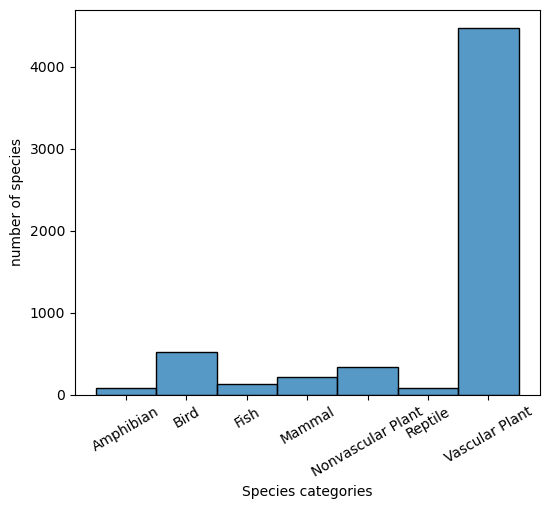

In [287]:
plt.figure(figsize=(6,5));
sns.histplot(conservationPerPark.category);
plt.xticks(rotation = 30);
plt.xlabel("Species categories");
plt.ylabel('number of species');
plt.show();

In [288]:
conservationStatusCategory = conservationPerPark[conservationPerPark.conservation_status != "No status"].groupby(["conservation_status", "category"])['scientific_name'].count().unstack().reset_index();
print(conservationStatusCategory)
unique_conservation_status = list(conservationStatusCategory.conservation_status.unique());

category conservation_status  Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  Vascular Plant
0                 Endangered        1.0   4.0   3.0     7.0                NaN      NaN             1.0
1                In Recovery        NaN   3.0   NaN     1.0                NaN      NaN             NaN
2         Species of Concern        4.0  72.0   4.0    28.0                5.0      5.0            43.0
3                 Threatened        2.0   NaN   4.0     2.0                NaN      NaN             2.0


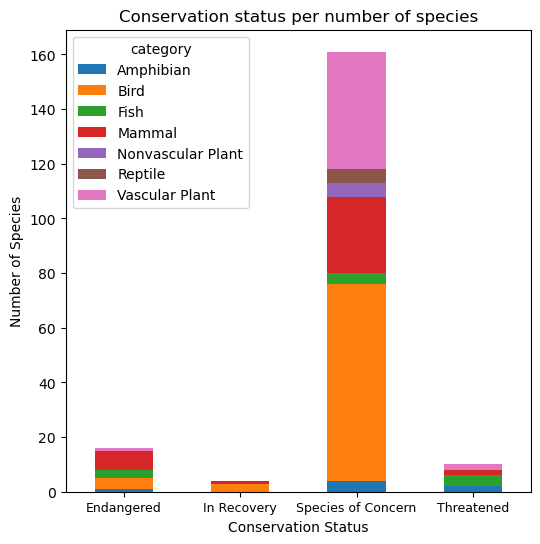

In [289]:
ax = conservationStatusCategory.plot(kind = 'bar', stacked = True, figsize=(6,6));
plt.xticks(fontsize = 9, rotation = 0);
ax.set_xticklabels(unique_conservation_status);
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");
ax.set_title("Conservation status per number of species");
plt.show();

In [290]:
speciesAtRisk = conservationPerPark[conservationPerPark.conservation_status != 'No status'];
speciesAtRisk = speciesAtRisk.drop_duplicates(subset = speciesAtRisk.columns[:2]);
categoryStatus_df = speciesAtRisk[speciesAtRisk.conservation_status != 'No status'].groupby(["category","conservation_status"])['scientific_name'].count().unstack().reset_index();
print(categoryStatus_df);

conservation_status           category  Endangered  In Recovery  Species of Concern  Threatened
0                            Amphibian         1.0          NaN                 4.0         2.0
1                                 Bird         4.0          3.0                68.0         NaN
2                                 Fish         3.0          NaN                 4.0         4.0
3                               Mammal         6.0          NaN                22.0         2.0
4                    Nonvascular Plant         NaN          NaN                 5.0         NaN
5                              Reptile         NaN          NaN                 5.0         NaN
6                       Vascular Plant         1.0          NaN                43.0         2.0


In [ ]:
#fig, [[axis, axis1] , [axis2 , axis3]] = plt.subplots(2, 2, sharey = True, figsize = (6, 5));
#axis= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['Endangered']);
#plt.xlabel("species");
#plt.ylabel('Total count');
#axis1= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['In Recovery']);
#plt.xlabel("species");
#plt.ylabel('Total count');
#axis2= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['Species of Concern']);
#plt.xlabel("species");
#plt.ylabel('Total count');
#axis3= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['Threatened']);
#plt.xlabel("species");
#plt.ylabel('Total count');

In [291]:
categoryStatus_df['Total count'] = categoryStatus_df[unique_conservation_status].agg('sum', axis = 1);
#print(unique_conservation_status)
print(categoryStatus_df)

conservation_status           category  Endangered  In Recovery  Species of Concern  Threatened  Total count
0                            Amphibian         1.0          NaN                 4.0         2.0          7.0
1                                 Bird         4.0          3.0                68.0         NaN         75.0
2                                 Fish         3.0          NaN                 4.0         4.0         11.0
3                               Mammal         6.0          NaN                22.0         2.0         30.0
4                    Nonvascular Plant         NaN          NaN                 5.0         NaN          5.0
5                              Reptile         NaN          NaN                 5.0         NaN          5.0
6                       Vascular Plant         1.0          NaN                43.0         2.0         46.0


In [292]:
categoryRiskStatus = conservationPerPark[conservationPerPark.conservation_status == 'No status'];
categoryRiskStatus = categoryRiskStatus.drop_duplicates(subset = categoryRiskStatus.columns[:2]);
categoryRiskStatus['With Risk'] =  categoryRiskStatus.conservation_status != 'No status'
categoryRiskStatus = categoryRiskStatus.groupby(['With Risk','category']).scientific_name.nunique().reset_index().pivot(columns = 'With Risk', index = 'category', values = 'scientific_name').reset_index();
categoryRiskStatus['Total count'] = categoryStatus_df[unique_conservation_status].agg('sum', axis = 1);
categoryRiskStatus.columns = ['category','No Risk','With Risk'];
categoryRiskStatus['With Risk'] = np.round(categoryRiskStatus['With Risk']).astype(int);
print(categoryRiskStatus);

            category  No Risk  With Risk
0          Amphibian       72          7
1               Bird      413         75
2               Fish      115         11
3             Mammal      146         30
4  Nonvascular Plant      328          5
5            Reptile       73          5
6     Vascular Plant     4216         46


In [293]:
categoryRiskStatus = categoryRiskStatus.assign(Percentage = lambda x: (x['With Risk'] / (x['With Risk'] + x['No Risk']) * 100));
print(categoryRiskStatus);

            category  No Risk  With Risk  Percentage
0          Amphibian       72          7    8.860759
1               Bird      413         75   15.368852
2               Fish      115         11    8.730159
3             Mammal      146         30   17.045455
4  Nonvascular Plant      328          5    1.501502
5            Reptile       73          5    6.410256
6     Vascular Plant     4216         46    1.079305


In [294]:
# calling chi_square to verify p-value between Mammal and Bird
contingency1 = [[30, 146],[75, 413]]
chi2_contingency(contingency1);
print(chi2_contingency(contingency1));

(0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))


In [295]:
# calling chi_square to verify p-value between Mammal and Reptile
contingency2 = [[30, 146],[5, 73]]
chi2_contingency(contingency2);
print(chi2_contingency(contingency2));

(4.289183096203645, 0.03835559022969898, 1, array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))


In [296]:
# calling chi_square to verify p-value between Mammal and Fish
contingency3 = [[30, 146],[11, 115]]
chi2_contingency(contingency3);
print(chi2_contingency(contingency3));

(3.647651024981415, 0.0561483484489001, 1, array([[ 23.89403974, 152.10596026],
       [ 17.10596026, 108.89403974]]))


In [309]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = conservationPerPark[conservationPerPark.category == "Mammal"].common_names.apply(remove_punctuations).str.split().tolist();
cleanRows = [];
for name in common_Names:
    name = list(dict.fromkeys(name));
    cleanRows.append(name);

commonNamesList = list(chain.from_iterable(name if isinstance(name, list) else [name] for name in cleanRows));
print(commonNamesList);

['Eurasian', 'Elk', 'Moose', 'Yellowstone', 'Moose', 'Antelope', 'Pronghorn', 'Pallid', 'Bat', 'Sierra', 'Nevada', 'Mountain', 'Beaver', 'Ringtail', 'Bison', 'Buffalo', 'Northern', 'Short', 'Tailed', 'Shrew', 'ShortTailed', 'American', 'Bison', 'Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated', 'GoldenMantled', 'Ground', 'Squirrel', 'Coyote', 'Gray', 'Wolf', 'Gray', 'Wolf', 'Gray', 'Wolf', 'Red', 'Wolf', 'American', 'Beaver', 'American', 'Beaver', 'Beaver', 'Rocky', 'Mountain', 'Elk', 'Wapiti', 'Or', 'Elk', 'California', 'Pocket', 'Mouse', 'Southern', 'RedBacked', 'Vole', 'Gappers', 'RedBacked', 'Vole', 'StarNosed', 'Mole', 'Rafinesques', 'BigEared', 'Bat', 'MuleEared', 'Bat', 'Pacific', 'Townsends', 'BigEared', 'Western', 'LongEared', 'LumpNosed', 'Townsends', 'BigEared', 'Bat', 'Least', 'Shrew', 'Virginia', 'Opossum', 'Virginia', 'Opossum', 'Oppossum', 'Big', 'Brown', 'Bat', 'Big', 'Brown', 'Bat', 'Feral', 'Horse', 'Common', 'Porcupine', 'Porcupine', 'Spotted', 'Bat', 'Western

In [310]:
common_words_count = [];

for name in commonNamesList:
    count = commonNamesList.count(name);
    common_words_count.append((name,count));

common_words_df = pd.DataFrame(set(common_words_count), columns =['Word', 'Count']).sort_values("Count", ascending = False);
print(common_words_df.head(10));



         Word  Count
194       Bat     23
159     Shrew     18
202    Myotis     17
76      Mouse     16
11   Chipmunk     13
146  Squirrel     12
88   American     12
65    Eastern     11
40       Vole     11
118  Mountain     10


In [316]:
conservationPerPark['bat specie'] = conservationPerPark.common_names.str.contains(r"\bBat\b", regex = True)
print(conservationPerPark[conservationPerPark['bat specie']]);

park_name category            scientific_name                                       common_names conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park  is_bat  bat specie
731         Mammal         Antrozous pallidus                             Pallid Bat, Pallid Bat  Species of Concern            67.000000                                 61.0                 244.000000                   134.0    True        True
753         Mammal   Corynorhinus rafinesquii                         Rafinesque's Big-Eared Bat           No status            57.000000                                 80.0                 259.000000                   188.0    True        True
754         Mammal    Corynorhinus townsendii  Mule-Eared Bat, Pacific Townsend's Big-Eared B...           No status           113.000000                                 92.5                 253.000000                   147.0    True        True
755         Mamm

In [317]:
conservationPerPark['shrew specie'] = conservationPerPark.common_names.str.contains(r"\Shrew\b", regex = True)
print(conservationPerPark[conservationPerPark['shrew specie']]);

park_name category     scientific_name                                       common_names conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park  is_bat  bat specie  shrew specie
735         Mammal  Blarina brevicauda  Northern Short Tailed Shrew, Northern Short-Ta...           No status                 77.0                                 86.0                      244.0                   185.0   False       False          True
756         Mammal     Cryptotis parva                                        Least Shrew           No status                153.0                                 68.0                      277.0                   152.0   False       False          True
881         Mammal      Sorex cinereus         Cinereus Shrew, Common Shrew, Masked Shrew           No status                117.0                                 66.0                      264.5                   121.5   False       False   